<a href="https://colab.research.google.com/github/topisan/medical_imaging/blob/master/project_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [13]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 


In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [17]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

Read WSI from tumor_091.tif with width: 61440, height: 53760


In [18]:
tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [19]:
tumor_mask

OpenSlide('tumor_091_mask.tif')

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

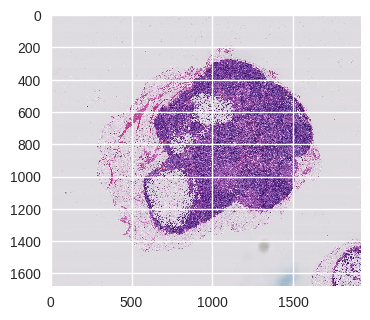

In [21]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(4,4), dpi=100)
plt.imshow(slide_image)

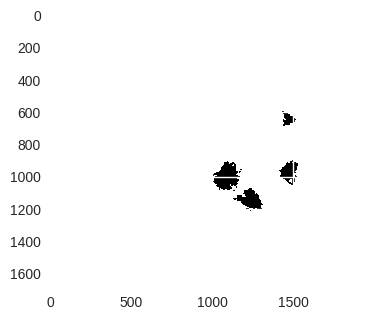

In [22]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(4,4), dpi=100)
plt.imshow(mask_image)

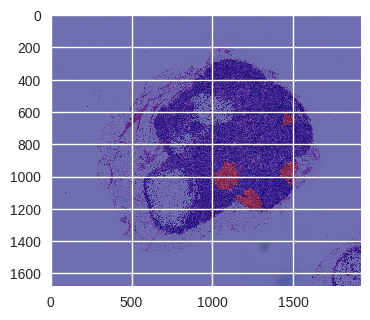

In [23]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(4,4), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

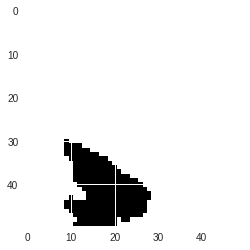

In [24]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


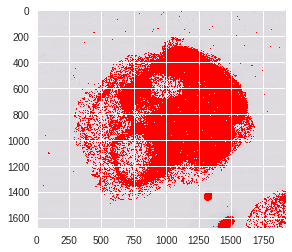

In [25]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [26]:
region = read_slide(tumor_mask, x=1*1000000000000000, y=120*128, level=7, width=50, height=50)[:,:,0]
tumor_mask.level_dimensions[7]
print(region.shape)

(50, 50)


In [0]:
# iterating through patches of masks to get zero and ones
def getting_labels(tumor_mask, slide):
  a=0
  b=0
  labels=[]
  slides_patches=[]
  mask_patches=[]
  for y_counter in range(0,7):
    a=0
    for x_counter in range(0,8):
      region_mask = read_slide(tumor_mask, x=a*32,y=b*32, level=5, width=240, height=240)[:,:,0]
      region_slide = read_slide(slide, x=a*32, y=b*32, level=5, width=240,height=240)[:,:,:]
      slides_patches.append(region_slide)
      mask_patches.append(region_mask)
      if region_mask.any()!=0:
        labels.append(1)
      else: 
        labels.append(0)
      a=a+240
    b=b+240
    
  return labels, slides_patches, mask_patches

In [0]:
labels, slides_patches, mask_patches = getting_labels(tumor_mask, slide)

In [75]:
labels[22]

1

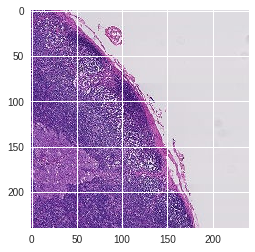

In [76]:
plt.imshow(slides_patches[22])

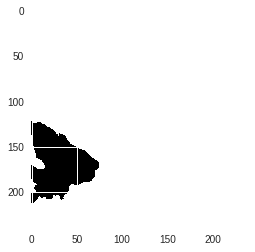

In [77]:
plt.imshow(mask_patches[22])

In [0]:
slide_path_2 = 'tumor_091.tif'
tumor_mask_path_2 = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path_2):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path_2):
  !curl -O $mask_url
  
slide_2 = open_slide(slide_path_2)  
tumor_mask_2 = open_slide(tumor_mask_path_2)

In [0]:
labels_2, slides_patches_2, mask_patches_= getting_labels(tumor_mask_2, slide_2)

In [0]:
slides_patches.extend(slides_patches_2)

In [0]:
labels.extend(labels_2)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_data_label_encoded=le.fit_transform(labels)
y_data_label_encoded=to_categorical(y_data_label_encoded,2)

In [0]:
# creating a model 
# weights = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(VGG16(include_top = False, weights = 'imagenet', input_shape = (240,240,3)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [0]:
slides_patches = np.array(slides_patches)

In [62]:
slides_patches.shape

(112, 240, 240, 3)

In [63]:
import pandas as pd
pd.Series(labels).value_counts()

0    94
1    18
dtype: int64

In [64]:
pd.Series(labels).value_counts()/len(labels)

0    0.839286
1    0.160714
dtype: float64

In [65]:
model.fit(slides_patches,y_data_label_encoded, epochs = 5, validation_split = 0.20)

Train on 89 samples, validate on 23 samples
Epoch 1/5
89/89 [==============================] - 220s 2s/step - loss: 3.3013 - acc: 0.6629 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 2/5
89/89 [==============================] - 215s 2s/step - loss: 2.5354 - acc: 0.8427 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 3/5
89/89 [==============================] - 218s 2s/step - loss: 2.5354 - acc: 0.8427 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 4/5
89/89 [==============================] - 217s 2s/step - loss: 2.5354 - acc: 0.8427 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 5/5
89/89 [==============================] - 217s 2s/step - loss: 2.5354 - acc: 0.8427 - val_loss: 2.8031 - val_acc: 0.8261


In [0]:
# Download the whole slide image
if not os.path.exists('tumor_019.tif'):
  !curl -O $slide_url
slide_path_3 = 'tumor_019.tif'
slide_3 = open_slide(slide_path_3)

In [0]:

def getting_patches_from_slides(slide):
  a=0
  b=0
#   labels=[]
  slides_patches=[]
#   mask_patches=[]
  for y_counter in range(0,7):
    a=0
    for x_counter in range(0,8):
#       region_mask = read_slide(tumor_mask, x=a*32,y=b*32, level=5, width=240, height=240)[:,:,0]
      region_slide = read_slide(slide, x=a*32, y=b*32, level=5, width=240,height=240)[:,:,:]
      slides_patches.append(region_slide)
#       mask_patches.append(region_mask)
#       if region_mask.any()!=0:
#         labels.append(1)
#       else: 
#         labels.append(0)
      a=a+240
    b=b+240
    
  return slides_patches

In [0]:
slides_3_patches = getting_patches_from_slides(slide_3)

In [69]:
slides_3_patches[0].shape

(240, 240, 3)

In [0]:
slides_3_patches = np.array(slides_3_patches)

In [72]:
model.predict(slides_3_patches)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)